In [2]:
import numpy as np 
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib #
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, RocCurveDisplay,confusion_matrix
from sklearn.model_selection import KFold
import mlflow
import mlflow.sklearn
print("Numpy: {}".format(np.__version__))
print("Pandas: {}".format(pd.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("seaborn: {}".format(sns.__version__))
print("Scikit-Learn: {}".format(sk.__version__))
print("MLFlow: {}".format(mlflow.__version__))

Numpy: 1.26.1
Pandas: 1.2.5
matplotlib: 3.8.1
seaborn: 0.13.0
Scikit-Learn: 1.3.2
MLFlow: 2.8.1


In [3]:
data = pd.read_csv("C:\\Users\\um6p\\Desktop\\M1\\M2\\kelloubi\\assignment\\IMDB_Dataset.csv")

## data preprocessing

In [6]:
data = data.iloc[:25000, :]
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
#check nan values in our dataset
data.isna().sum()

review       0
sentiment    0
dtype: int64

#### Removing HTML tags

In [8]:
import re
def tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'',text)

In [9]:
data['review'] = data['review'].apply(tags)

In [10]:
data['review'][1]

'A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well done.'

#### Removing punctuations :

In [11]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
exclude = string.punctuation

In [13]:
def punct(text):
    return text.translate(str.maketrans('','',exclude))

In [14]:
data['review'] = data['review'].apply(punct)

In [15]:
data['review'][1]

'A wonderful little production The filming technique is very unassuming very oldtimeBBC fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece The actors are extremely well chosen Michael Sheen not only has got all the polari but he has all the voices down pat too You can truly see the seamless editing guided by the references to Williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece A masterful production about one of the great masters of comedy and his life The realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears It plays on our knowledge and our senses particularly with the scenes concerning Orton and Halliwell and the sets particularly of their flat with Halliwells murals decorating every surface are terribly well done'

#### Remove stopwords :

In [16]:
from nltk.corpus import stopwords
sw = stopwords.words('english')
data['review'] = data['review'].apply(lambda x:[word for word in x.split() if word not in sw]).apply(lambda x:" ".join(x))

In [17]:
x = data['review'].copy()
y = data['sentiment'].copy()

In [18]:
#data splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

##### In the following, for reveiws processing, I used CountVectorizer that aims to convert a collection of text documents to a matrix of token counts.

In [19]:
vectorizer = CountVectorizer()

In [20]:
x_train_transformed = vectorizer.fit_transform(x_train)

## 1. Model training :

In [21]:
from sklearn.metrics import accuracy_score, classification_report

In [22]:
import mlflow
def evaluate(sk_model, x_test, y_test):
    eval_acc = sk_model.score(x_test, y_test)
    preds = sk_model.predict(x_test)
    auc_score = accuracy_score(y_test, preds)
    mlflow.log_metric("eval_acc", eval_acc) # nous avons fait la même chose pour l'accuracy de test (evaluation)
    mlflow.log_metric("auc_score", auc_score)# aussi pour l'AUC score 
    print(f"Auc Score: {auc_score:.3%}")
    print(f"Eval Accuracy: {eval_acc:.3%}")
    #roc_plot = RocCurveDisplay.plot(sk_model, x_test, y_test)
    #plot_roc_curve(sk_model, x_test, y_test,name='Scikit-learn ROC Curve')
    #plt.savefig("sklearn_roc_plot.png")
    #plt.show()
    plt.clf()
    conf_matrix = confusion_matrix(y_test, preds)
    ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.savefig("sklearn_conf_matrix.png")
    # nous avons dit à MLflow de sauvegarder ces deux figure afin de les consulter à chaque 
    # exécution d'une façon organisée comme nous allons le voir plus loin dans cet atelier  
    #mlflow.log_artifact("sklearn_roc_plot.png")
    mlflow.log_artifact("sklearn_conf_matrix.png")

In [42]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import mlflow
from mlflow.sklearn import log_model

vectorizer = CountVectorizer()
X_transformed = vectorizer.fit_transform(data['review'])

with open('X_transformed.pkl', 'wb') as transformed_file:
    pickle.dump(X_transformed, transformed_file)

def model_experiment(model, model_name):
    mlflow.set_experiment("scikit_learn_experiment")
    with mlflow.start_run():
        params = {
            "max_iter": 1,
            "penalty": 'L1',
            "solver": 'liblinear',
        }
        mlflow.log_params(params)
        model_opt = model.fit(vectorizer.fit_transform(x_train), y_train)
        train_acc = model_opt.score(vectorizer.transform(x_train), y_train)
        mlflow.log_metric("train_acc", train_acc)
        print(f"Train Accuracy: {train_acc:.3%}")
        
        # Log the transformed data as an artifact
        mlflow.log_artifact('X_transformed.pkl', artifact_path="artifacts")

        evaluate(model_opt, vectorizer.transform(x_test), y_test)
        
        # Log the model
        mlflow.sklearn.log_model(model_opt, model_name)
        
        print("Model run: ", mlflow.active_run().info.run_uuid)
    mlflow.end_run()



### Test Decision Tree :

In [24]:
from sklearn.tree import DecisionTreeClassifier

Train Accuracy: 100.000%
Auc Score: 71.600%
Eval Accuracy: 71.600%
Model run:  08d32b1413fb43de83944a4a0372e2e6


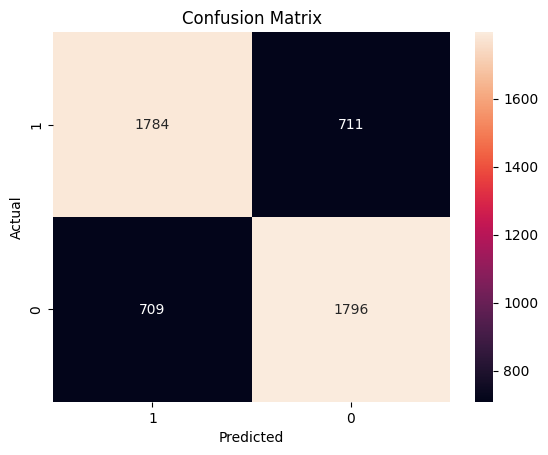

In [25]:
# Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42)
model_experiment(dt_model, "DecisionTreeClassifier")

### Test Random Forest :

In [26]:
from sklearn.ensemble import RandomForestClassifier

Train Accuracy: 100.000%
Auc Score: 84.880%
Eval Accuracy: 84.880%
Model run:  65584435546f422cbd06f0d45a809e02


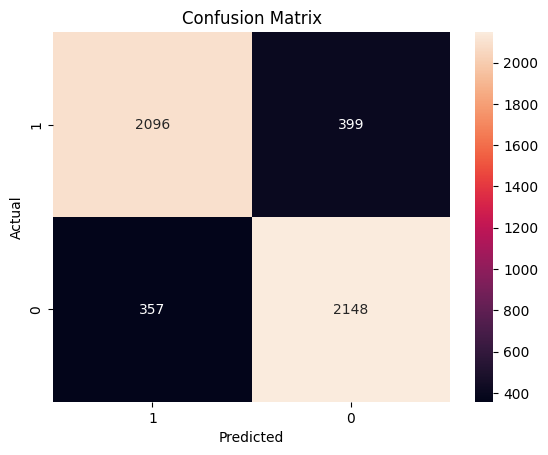

In [27]:
rf = RandomForestClassifier()
model_experiment(rf, "Randomforestclassifier")

### Logistic regression :

In [40]:
from sklearn.linear_model import LogisticRegression

c:\Users\um6p\.pyenv\pyenv-win\versions\3.9.5\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Accuracy: 99.910%
Auc Score: 87.560%
Eval Accuracy: 87.560%
Model run:  ca0a785f56494ad086034d03bdd169f6


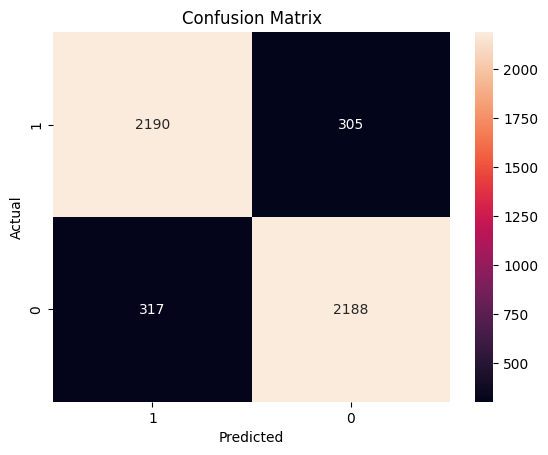

In [43]:
rf = LogisticRegression()
model_experiment(rf, "Logistic Regression")

### Test Support vector Machine model :

In [30]:
from sklearn.svm import SVC
svm_model = SVC(kernel='linear', random_state=42)

Train Accuracy: 100.000%
Auc Score: 85.920%
Eval Accuracy: 85.920%
Model run:  c1b5cb942f5a4ce492e3c6ae20a63b16


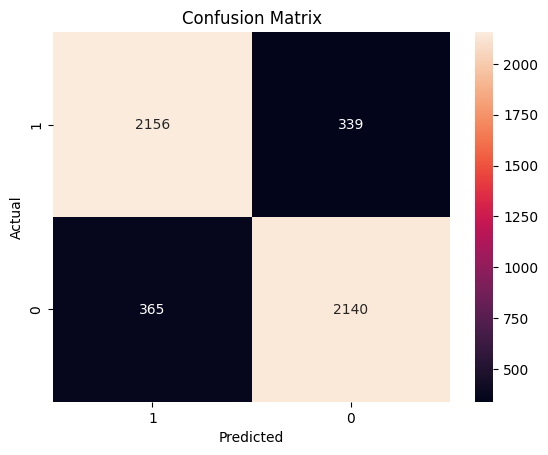

In [31]:
model_experiment(svm_model, "SVMmodel")

In [23]:
import pickle
import onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

example_input = ["example text"]

initial_type = [('float_input', FloatTensorType([None, len(example_input[0])]))] 
onnx_model = convert_sklearn(model_opt, initial_types=initial_type)

onnx.save_model(onnx_model, 'logistic_regression_model.onnx')

onnx.checker.check_model(onnx_model)


In [86]:
# Find the best model
best_run = mlflow.search_runs(order_by=["metrics.auc_score"]).iloc[0]
best_run_id = best_run.run_id
 
# Retrieve the artifact URI for the 'model' directory
best_model_uri = mlflow.get_run(run_id=best_run_id).info.artifact_uri

In [80]:
best_model_uri

'file:///c:/Users/um6p/Desktop/M1/M2/kelloubi/assignment/mlruns/931435339774998555/08d32b1413fb43de83944a4a0372e2e6/artifacts'

In [ ]:
best_model = mlflow.sklearn.load_model(best_model_uri+"/Randomforestclassifier/model.pkl")
initial_type = [('float_input',FloatTensorType([None, x_train.shape[1]]))]
onnx_model = convert_sklearn(best_model, initial_types=initial_type)
onnx.save_model(onnx_model, "../models/best_model.onnx")